# Sorghum Yield Predictions with Ensemble Models

In [139]:
#important libraries
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error,explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import  RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import KFold, RepeatedKFold
from matplotlib import pyplot
from scipy.stats import sem
from numpy import mean
from numpy import std
import scipy as sp

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px

import itertools
from itertools import permutations
pd.set_option("display.max_rows", None, "display.max_columns", None)
sns.set()

%matplotlib inline

### Important Functions

In [212]:
def make_eda_plots(df, np_func):
    summ = df.copy()
    summ.Treatment = summ.Treatment.apply(lambda x: "High Nitrogen" if x=="HN" else "Low Nitrogen" )
    summ= pd.pivot_table(data =summ, values = list(summ.columns)[18:-6], index = summ.Treatment, aggfunc = np_func).transpose()
    summ.sort_index(inplace = True)
    summ.reset_index(inplace = True)
    summ['index'] = summ['index'].apply(lambda x: x[1:])
    summ['index'] = summ['index'].astype('int64')
    summ.sort_values('index', inplace =True)
    summ.set_index('index', inplace = True)
    print(summ.head())
    plt.figure(figsize=(20,8))
    plt.xticks(rotation=45)
    sns.lineplot(data=summ)
    plt.xlabel('Wavelengths')
    plt.ylabel('Standard Deviations  of Reflectance Intensity')
    plt.tight_layout()

## Import Train and Test Data

In [141]:
df = pd.read_csv('../../data/data-1.5-yellow.csv',index_col = 0)
print(df.shape)
df.head(3)

(834, 2170)


PlotID Treatment         PI       CHL       EWT       LWC        SLA  \
0    5001        HN  PI 656057  467.6750  0.048621  0.816438  91.477861   
1    5002        HN  PI 656011  512.3625  0.043236  0.768144  76.626487   
2    5003        HN  PI 576347  606.6625  0.033848  0.751805  89.492182   

       N      P     K     Mg     Ca      S     Fe    Mn    B    Cu    Zn  \
0  3.612  0.381  1.93  0.245  0.674  0.206  171.0  31.0  6.4  17.6  28.0   
1  2.916  0.387  2.24  0.143  0.447  0.196  134.0  34.0  4.6  12.5  27.0   
2  3.749  0.492  1.54  0.260  0.583  0.196  159.0  36.0  5.1  15.4  32.0   

       X350      X351      X352      X353      X354      X355      X356  \
0  0.085242  0.084198  0.073049  0.062852  0.071412  0.076959  0.086402   
1  0.053529  0.087761  0.089831  0.066536  0.070464  0.065440  0.057905   
2  0.133649  0.113164  0.095398  0.095292  0.097985  0.089531  0.085457   

       X357      X358      X359      X360      X361      X362      X363  \
0  0.089655  0.068680  0.077627  0.075629  0.049378  0.047664  0.048732   
1  0.061879  0.087529  0.083688  0.066741  0.054267  0.042131  0.050978   
2  0.086694  0.082119  0.090674  0.082183  0.057630  0.074017  0.063699   

       X364      X365      X366      X367      X368      X369      X370  \
0  0.053430  0.059725  0.043177  0.055788  0.069612  0.049814  0.054452   
1  0.056994  0.045107  0.046368  0.043490  0.042569  0.050927  0.046258   
2  0.056483  0.072555  0.051468  0.052361  0.063759  0.055830  0.039474   

       X371      X372      X373      X374      X375      X376      X377  \
0  0.055179  0.045720  0.038621  0.047542  0.053812  0.049443  0.042255   
1  0.041853  0.043365  0.048262  0.047062  0.048264  0.051650  0.044692   
2  0.044329  0.059886  0.055076  0.055611  0.054215  0.045810  0.032091   

       X378      X379      X380      X381      X382      X383      X384  \
0  0.043361  0.048633  0.051029  0.044424  0.043408  0.041854  0.032599   
1  0.043194  0.040966  0.035022  0.041995  0.044352  0.042166  0.041462   
2  0.028689  0.033169  0.038722  0.042077  0.040161  0.037917  0.041208   

       X385      X386      X387      X388      X389      X390      X391  \
0  0.041451  0.048299  0.048850  0.050056  0.046709  0.043648  0.042465   
1  0.043841  0.043980  0.042063  0.041588  0.038251  0.035009  0.034469   
2  0.046213  0.048145  0.046461  0.043884  0.043052  0.039607  0.035373   

       X392      X393      X394      X395      X396      X397      X398  \
0  0.038687  0.046113  0.051060  0.044858  0.047175  0.049994  0.049110   
1  0.037531  0.040736  0.042420  0.042195  0.041240  0.040235  0.039823   
2  0.041091  0.045182  0.045669  0.043754  0.042794  0.041254  0.040067   

       X399      X400      X401      X402      X403      X404      X405  \
0  0.043823  0.043862  0.041952  0.039572  0.044624  0.044988  0.046128   
1  0.040379  0.041654  0.042781  0.042810  0.041331  0.044993  0.048847   
2  0.040752  0.043151  0.043261  0.042180  0.044544  0.044126  0.043205   

       X406      X407      X408      X409      X410      X411      X412  \
0  0.048967  0.043201  0.043568  0.048380  0.051787  0.049475  0.048316   
1  0.048443  0.042648  0.044995  0.048170  0.044979  0.047369  0.049684   
2  0.043584  0.044392  0.045137  0.045063  0.044390  0.046864  0.045013   

       X413      X414      X415      X416      X417      X418      X419  \
0  0.046960  0.041976  0.046816  0.049948  0.048506  0.050128  0.048849   
1  0.049955  0.048659  0.048421  0.048269  0.048416  0.050394  0.048258   
2  0.043726  0.050980  0.051151  0.049499  0.049354  0.050059  0.049096   

       X420      X421      X422      X423      X424      X425      X426  \
0  0.048119  0.050257  0.051968  0.050424  0.047950  0.047706  0.047331   
1  0.048416  0.052975  0.049087  0.050950  0.054511  0.052481  0.052212   
2  0.048275  0.048961  0.049973  0.049505  0.048687  0.049145  0.049398   

       X427      X428      X429      X430      X431      X432      X433  \
0  0.047042

### Calculate Indices

In [142]:
#EVI: Ehnhanced Vegetation Index
indices = ['EVI','RNDVI','ARVI','VRI', 'NDVI']
df['EVI'] = df.apply(lambda x: (x['X802']-x['X682'])/(x['X802']+6), axis = 1)
#RNDVI: Red-edge Normalized Difference Vegetation Index
df['RNDVI'] = df.apply(lambda x: (x['X750']-x['X705'])/(x['X750']+x['X705']), axis = 1)
#ARVI: Atmospherically Resistant Vegetation Index
df['ARVI'] = df.apply(lambda x: (x['X800']-(2 * x['X670'])+x['X630'])/(x['X800']+(2 * x['X670'])+x['X630']), axis = 1)
#VRI: Vogelmann Red Edge Index
df['VRI'] = df.apply(lambda x: (x['X740'])/(x['X720']), axis = 1)
#NDVI: Normalized Difference Vegeation Index
df['NDVI'] = df.apply(lambda x: (x['X800']-x['X670'])/(x['X800']+x['X670']), axis = 1)


### Exploratory Data Analysis

Treatment  High Nitrogen  Low Nitrogen
index                                 
350             0.032292      0.027030
351             0.027438      0.025932
352             0.022215      0.025163
353             0.022430      0.027467
354             0.027803      0.026798


Text(0.5, 1.0, 'Standard Deviation of Reflectance Intensity Across Wavelngths')

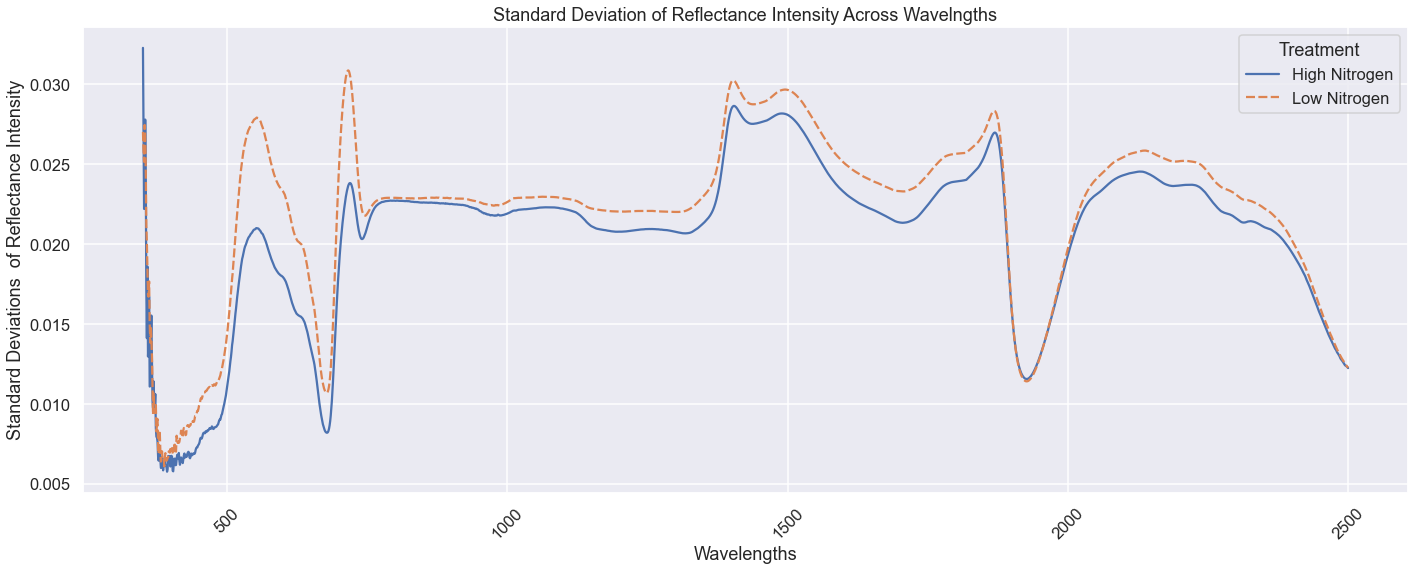

In [213]:
#average reflectanced
sns.set_context('talk')
make_eda_plots(df,np.std)
plt.title("Standard Deviation of Reflectance Intensity Across Wavelngths")

In [144]:
df.head(3)

PlotID Treatment         PI       CHL       EWT       LWC        SLA  \
0    5001        HN  PI 656057  467.6750  0.048621  0.816438  91.477861   
1    5002        HN  PI 656011  512.3625  0.043236  0.768144  76.626487   
2    5003        HN  PI 576347  606.6625  0.033848  0.751805  89.492182   

       N      P     K     Mg     Ca      S     Fe    Mn    B    Cu    Zn  \
0  3.612  0.381  1.93  0.245  0.674  0.206  171.0  31.0  6.4  17.6  28.0   
1  2.916  0.387  2.24  0.143  0.447  0.196  134.0  34.0  4.6  12.5  27.0   
2  3.749  0.492  1.54  0.260  0.583  0.196  159.0  36.0  5.1  15.4  32.0   

       X350      X351      X352      X353      X354      X355      X356  \
0  0.085242  0.084198  0.073049  0.062852  0.071412  0.076959  0.086402   
1  0.053529  0.087761  0.089831  0.066536  0.070464  0.065440  0.057905   
2  0.133649  0.113164  0.095398  0.095292  0.097985  0.089531  0.085457   

       X357      X358      X359      X360      X361      X362      X363  \
0  0.089655  0.068680  0.077627  0.075629  0.049378  0.047664  0.048732   
1  0.061879  0.087529  0.083688  0.066741  0.054267  0.042131  0.050978   
2  0.086694  0.082119  0.090674  0.082183  0.057630  0.074017  0.063699   

       X364      X365      X366      X367      X368      X369      X370  \
0  0.053430  0.059725  0.043177  0.055788  0.069612  0.049814  0.054452   
1  0.056994  0.045107  0.046368  0.043490  0.042569  0.050927  0.046258   
2  0.056483  0.072555  0.051468  0.052361  0.063759  0.055830  0.039474   

       X371      X372      X373      X374      X375      X376      X377  \
0  0.055179  0.045720  0.038621  0.047542  0.053812  0.049443  0.042255   
1  0.041853  0.043365  0.048262  0.047062  0.048264  0.051650  0.044692   
2  0.044329  0.059886  0.055076  0.055611  0.054215  0.045810  0.032091   

       X378      X379      X380      X381      X382      X383      X384  \
0  0.043361  0.048633  0.051029  0.044424  0.043408  0.041854  0.032599   
1  0.043194  0.040966  0.035022  0.041995  0.044352  0.042166  0.041462   
2  0.028689  0.033169  0.038722  0.042077  0.040161  0.037917  0.041208   

       X385      X386      X387      X388      X389      X390      X391  \
0  0.041451  0.048299  0.048850  0.050056  0.046709  0.043648  0.042465   
1  0.043841  0.043980  0.042063  0.041588  0.038251  0.035009  0.034469   
2  0.046213  0.048145  0.046461  0.043884  0.043052  0.039607  0.035373   

       X392      X393      X394      X395      X396      X397      X398  \
0  0.038687  0.046113  0.051060  0.044858  0.047175  0.049994  0.049110   
1  0.037531  0.040736  0.042420  0.042195  0.041240  0.040235  0.039823   
2  0.041091  0.045182  0.045669  0.043754  0.042794  0.041254  0.040067   

       X399      X400      X401      X402      X403      X404      X405  \
0  0.043823  0.043862  0.041952  0.039572  0.044624  0.044988  0.046128   
1  0.040379  0.041654  0.042781  0.042810  0.041331  0.044993  0.048847   
2  0.040752  0.043151  0.043261  0.042180  0.044544  0.044126  0.043205   

       X406      X407      X408      X409      X410      X411      X412  \
0  0.048967  0.043201  0.043568  0.048380  0.051787  0.049475  0.048316   
1  0.048443  0.042648  0.044995  0.048170  0.044979  0.047369  0.049684   
2  0.043584  0.044392  0.045137  0.045063  0.044390  0.046864  0.045013   

       X413      X414      X415      X416      X417      X418      X419  \
0  0.046960  0.041976  0.046816  0.049948  0.048506  0.050128  0.048849   
1  0.049955  0.048659  0.048421  0.048269  0.048416  0.050394  0.048258   
2  0.043726  0.050980  0.051151  0.049499  0.049354  0.050059  0.049096   

       X420      X421      X422      X423      X424      X425      X426  \
0  0.048119  0.050257  0.051968  0.050424  0.047950  0.047706  0.047331   
1  0.048416  0.052975  0.049087  0.050950  0.054511  0.052481  0.052212   
2  0.048275  0.048961  0.049973  0.049505  0.048687  0.049145  0.049398   

       X427      X428      X429      X430      X431      X432      X433  \
0  0.047042

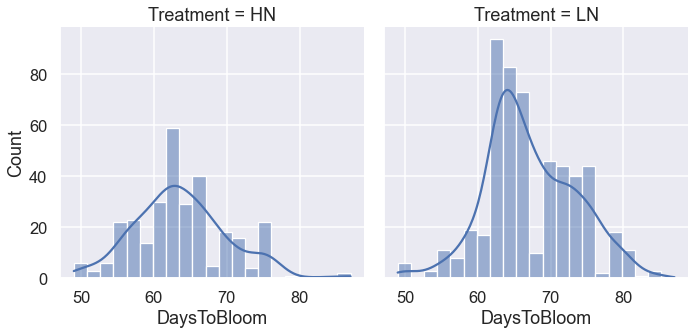

In [145]:
#distribution plot of daystobloom

sns.set_context('talk')
sns.displot(data = df, x = 'DaysToBloom', col = 'Treatment', kde = True )


C:\Users\anishimwe2\.conda\envs\iea\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anishimwe2\.conda\envs\iea\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


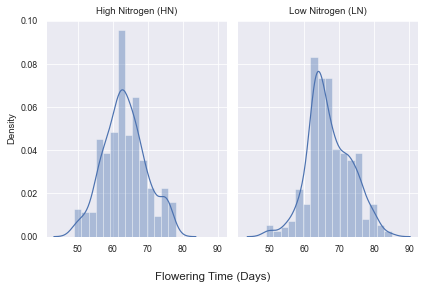

In [194]:
#drop outliers in HN with DaysToBloom over 80
df= df[((df['DaysToBloom']<80) & (df.Treatment == "HN")) | (df.Treatment == "LN")]
#distribution plot of daystobloom
sns.set_context('paper')
f, (ax1,ax2)  = plt.subplots(1, 2, sharex=True, sharey= True)
sns.distplot( x = df[df.Treatment =="HN"]['DaysToBloom'],  kde =True, norm_hist = True, ax = ax1)
sns.distplot( x = df[df.Treatment =="LN"]['DaysToBloom'],  kde =True, norm_hist = True, ax = ax2)
plt.ylabel("")
ax1.set_title("High Nitrogen (HN)")
ax2.set_title("Low Nitrogen (LN)")
f.supxlabel("Flowering Time (Days)")
plt.tight_layout()


In [147]:
df[['DaysToBloom']][df.Treatment =="LN"].describe(), df[['DaysToBloom']][df.Treatment =="HN"].describe()

(       DaysToBloom
 count   533.000000
 mean     67.187617
 std       6.192592
 min      49.000000
 25%      63.000000
 50%      66.000000
 75%      72.000000
 max      85.000000,
        DaysToBloom
 count   298.000000
 mean     63.520134
 std       6.039260
 min      49.000000
 25%      60.000000
 50%      63.000000
 75%      67.000000
 max      78.000000)

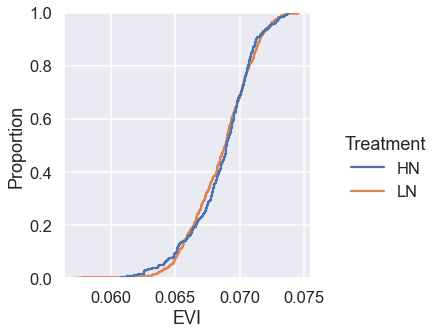

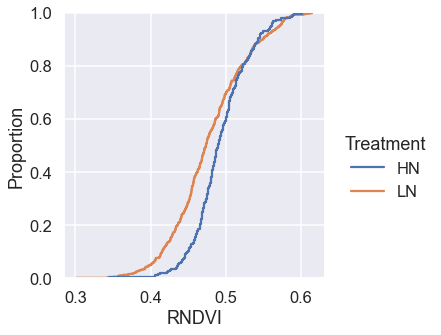

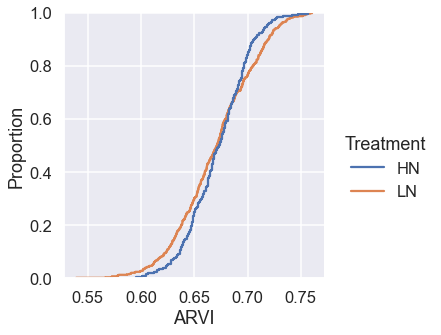

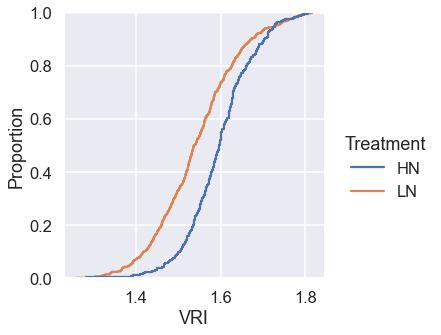

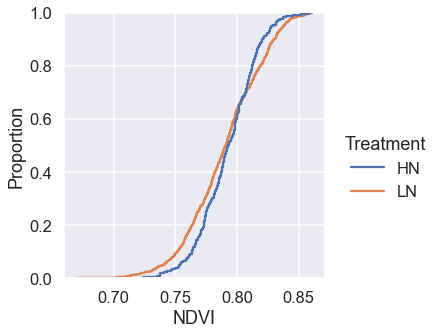

In [148]:
#distribution plot of daystobloom
for i in indices: 
    sns.set_context('talk')
    sns.displot(data = df, x = i, hue = 'Treatment', kind = 'ecdf')
    #print(df[[i]][df.Treatment =="LN"].describe(), df[[i]][df.Treatment =="HN"].describe())


### Calculate Principal Components

In [149]:
df.head(3)

PlotID Treatment         PI       CHL       EWT       LWC        SLA  \
1    5002        HN  PI 656011  512.3625  0.043236  0.768144  76.626487   
2    5003        HN  PI 576347  606.6625  0.033848  0.751805  89.492182   
3    5014        HN  PI 534117       NaN       NaN       NaN        NaN   

       N      P     K     Mg     Ca      S     Fe    Mn    B    Cu    Zn  \
1  2.916  0.387  2.24  0.143  0.447  0.196  134.0  34.0  4.6  12.5  27.0   
2  3.749  0.492  1.54  0.260  0.583  0.196  159.0  36.0  5.1  15.4  32.0   
3    NaN    NaN   NaN    NaN    NaN    NaN    NaN   NaN  NaN   NaN   NaN   

       X350      X351      X352      X353      X354      X355      X356  \
1  0.053529  0.087761  0.089831  0.066536  0.070464  0.065440  0.057905   
2  0.133649  0.113164  0.095398  0.095292  0.097985  0.089531  0.085457   
3  0.119853  0.089598  0.093482  0.111414  0.079122  0.059123  0.080614   

       X357      X358      X359      X360      X361      X362      X363  \
1  0.061879  0.087529  0.083688  0.066741  0.054267  0.042131  0.050978   
2  0.086694  0.082119  0.090674  0.082183  0.057630  0.074017  0.063699   
3  0.111972  0.087410  0.104930  0.096836  0.053224  0.080590  0.084966   

       X364      X365      X366      X367      X368      X369      X370  \
1  0.056994  0.045107  0.046368  0.043490  0.042569  0.050927  0.046258   
2  0.056483  0.072555  0.051468  0.052361  0.063759  0.055830  0.039474   
3  0.075567  0.074128  0.078823  0.067031  0.053021  0.057072  0.060873   

       X371      X372      X373      X374      X375      X376      X377  \
1  0.041853  0.043365  0.048262  0.047062  0.048264  0.051650  0.044692   
2  0.044329  0.059886  0.055076  0.055611  0.054215  0.045810  0.032091   
3  0.065333  0.067081  0.061981  0.071762  0.075621  0.067405  0.063775   

       X378      X379      X380      X381      X382      X383      X384  \
1  0.043194  0.040966  0.035022  0.041995  0.044352  0.042166  0.041462   
2  0.028689  0.033169  0.038722  0.042077  0.040161  0.037917  0.041208   
3  0.060381  0.061531  0.067389  0.065502  0.061511  0.059425  0.060912   

       X385      X386      X387      X388      X389      X390      X391  \
1  0.043841  0.043980  0.042063  0.041588  0.038251  0.035009  0.034469   
2  0.046213  0.048145  0.046461  0.043884  0.043052  0.039607  0.035373   
3  0.060602  0.060764  0.061790  0.062637  0.064547  0.063739  0.060583   

       X392      X393      X394      X395      X396      X397      X398  \
1  0.037531  0.040736  0.042420  0.042195  0.041240  0.040235  0.039823   
2  0.041091  0.045182  0.045669  0.043754  0.042794  0.041254  0.040067   
3  0.061476  0.058410  0.057525  0.062045  0.058640  0.057564  0.058823   

       X399      X400      X401     X402      X403      X404      X405  \
1  0.040379  0.041654  0.042781  0.04281  0.041331  0.044993  0.048847   
2  0.040752  0.043151  0.043261  0.04218  0.044544  0.044126  0.043205   
3  0.058657  0.056359  0.056490  0.05914  0.060611  0.057030  0.055395   

       X406      X407      X408      X409      X410      X411      X412  \
1  0.048443  0.042648  0.044995  0.048170  0.044979  0.047369  0.049684   
2  0.043584  0.044392  0.045137  0.045063  0.044390  0.046864  0.045013   
3  0.058313  0.059271  0.057111  0.056335  0.059869  0.060999  0.058410   

       X413      X414      X415      X416      X417      X418      X419  \
1  0.049955  0.048659  0.048421  0.048269  0.048416  0.050394  0.048258   
2  0.043726  0.050980  0.051151  0.049499  0.049354  0.050059  0.049096   
3  0.055625  0.057219  0.057485  0.059460  0.061833  0.058622  0.059130   

       X420      X421      X422      X423      X424      X425      X426  \
1  0.048416  0.052975  0.049087  0.050950  0.054511  0.052481  0.052212   
2  0.048275  0.048961  0.049973  0.049505  0.048687  0.049145  0.049398   
3  0.060123  0.058620  0.056882  0.059161  0.061531  0.059265  0.057416   

       X427      X428      X429      X430      X431      X432      X433  \
1  0.052104  0.

In [150]:
sub = df[df.columns[18:-6]] #reflectance data
sub.head()

X350      X351      X352      X353      X354      X355      X356  \
1  0.053529  0.087761  0.089831  0.066536  0.070464  0.065440  0.057905   
2  0.133649  0.113164  0.095398  0.095292  0.097985  0.089531  0.085457   
3  0.119853  0.089598  0.093482  0.111414  0.079122  0.059123  0.080614   
4  0.087480  0.102200  0.112072  0.109021  0.096971  0.088650  0.079650   
5  0.120226  0.070748  0.053416  0.070563  0.062600  0.046475  0.061267   

       X357      X358      X359      X360      X361      X362      X363  \
1  0.061879  0.087529  0.083688  0.066741  0.054267  0.042131  0.050978   
2  0.086694  0.082119  0.090674  0.082183  0.057630  0.074017  0.063699   
3  0.111972  0.087410  0.104930  0.096836  0.053224  0.080590  0.084966   
4  0.069502  0.061583  0.063581  0.063916  0.057499  0.052230  0.050146   
5  0.086586  0.061980  0.078884  0.087223  0.066724  0.066786  0.068153   

       X364      X365      X366      X367      X368      X369      X370  \
1  0.056994  0.045107  0.046368  0.043490  0.042569  0.050927  0.046258   
2  0.056483  0.072555  0.051468  0.052361  0.063759  0.055830  0.039474   
3  0.075567  0.074128  0.078823  0.067031  0.053021  0.057072  0.060873   
4  0.051929  0.057628  0.068537  0.071899  0.064342  0.049210  0.040311   
5  0.064134  0.055916  0.059502  0.050772  0.042891  0.052731  0.048797   

       X371      X372      X373      X374      X375      X376      X377  \
1  0.041853  0.043365  0.048262  0.047062  0.048264  0.051650  0.044692   
2  0.044329  0.059886  0.055076  0.055611  0.054215  0.045810  0.032091   
3  0.065333  0.067081  0.061981  0.071762  0.075621  0.067405  0.063775   
4  0.043344  0.052114  0.055250  0.051213  0.045734  0.043992  0.048554   
5  0.049588  0.052458  0.043302  0.051977  0.055814  0.048201  0.048429   

       X378      X379      X380      X381      X382      X383      X384  \
1  0.043194  0.040966  0.035022  0.041995  0.044352  0.042166  0.041462   
2  0.028689  0.033169  0.038722  0.042077  0.040161  0.037917  0.041208   
3  0.060381  0.061531  0.067389  0.065502  0.061511  0.059425  0.060912   
4  0.051052  0.050399  0.048936  0.053607  0.054198  0.049047  0.042811   
5  0.049429  0.050073  0.049999  0.047943  0.045547  0.044132  0.044034   

       X385      X386      X387      X388      X389      X390      X391  \
1  0.043841  0.043980  0.042063  0.041588  0.038251  0.035009  0.034469   
2  0.046213  0.048145  0.046461  0.043884  0.043052  0.039607  0.035373   
3  0.060602  0.060764  0.061790  0.062637  0.064547  0.063739  0.060583   
4  0.053208  0.055781  0.048785  0.046415  0.043908  0.047679  0.054650   
5  0.042231  0.042918  0.044714  0.043390  0.050289  0.052161  0.045801   

       X392      X393      X394      X395      X396      X397      X398  \
1  0.037531  0.040736  0.042420  0.042195  0.041240  0.040235  0.039823   
2  0.041091  0.045182  0.045669  0.043754  0.042794  0.041254  0.040067   
3  0.061476  0.058410  0.057525  0.062045  0.058640  0.057564  0.058823   
4  0.048783  0.052314  0.054007  0.045919  0.048827  0.052774  0.054797   
5  0.044632  0.047113  0.050603  0.051361  0.043024  0.043116  0.047659   

       X399      X400      X401      X402      X403      X404      X405  \
1  0.040379  0.041654  0.042781  0.042810  0.041331  0.044993  0.048847   
2  0.040752  0.043151  0.043261  0.042180  0.044544  0.044126  0.043205   
3  0.058657  0.056359  0.056490  0.059140  0.060611  0.057030  0.055395   
4  0.054688  0.052701  0.053489  0.055446  0.052672  0.051452  0.052453   
5  0.046490  0.046544  0.048318  0.049059  0.044705  0.043497  0.044946   

       X406      X407      X408      X409      X410      X411      X412  \
1  0.048443  0.042648  0.044995  0.048170  0.044979  0.047369  0.049684   
2  0.043584  0.044392  0.045137  0.045063  0.044390  0.046864  0.045013   
3  0.058313  0.059271  0.057111  0.056335  0.059869  0.060999  0.058410   
4  0.054213  0.053440  0.053335  0.055460  0.058738  0.055531  0.052192   
5  0.047421  0.050023  0

In [151]:
df.shape, sub.shape, len(df.PI.unique())

((831, 2175), (831, 2151), 341)

In [152]:
#clacualte 15 principal components
n_components =15
pca = PCA(n_components)
sub_trans = pca.fit_transform(sub)
sub_df = pd.DataFrame(data = sub_trans
         , columns = ["PC"+str(i) for i in list(range(1,n_components+1))])
sub_df.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,-0.199795,0.475168,-0.180586,0.039666,-0.048019,0.119211,-0.037106,-0.014908,0.020054,0.029521,-0.031861,-0.018250,-0.010368,0.017520,0.028504
1,0.090690,-0.413289,-0.094177,0.047305,-0.016289,0.017910,0.047469,-0.022164,0.026508,0.024055,0.004648,-0.002279,-0.017012,0.035588,0.027102
2,0.857476,-0.055503,-0.292810,0.167199,-0.104094,0.032286,-0.018998,0.010292,0.011132,-0.059544,0.025399,0.025521,0.009700,0.012001,-0.003276


In [153]:
total_var = pca.explained_variance_ratio_.sum() * 100
print(total_var)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

# plt.figure(figsize = (8,3))
# sns.set_context('paper')
# sns.barplot(x = list(range(1,n_components+1,1)), y = exp_var_cumul, color = 'grey')

99.70384638501847


In [154]:
# plt.figure(figsize=(8,6))
# sns.set_context("talk")
# sns.barplot(x = list(range(1,n_components+1,1)), y=pca.explained_variance_ratio_, color = 'grey')
# plt.ylabel("Explained Variance")
# plt.xlabel("Principal Components")
# plt.plot(exp_var_cumul)

In [155]:
df1 = pd.DataFrame({
    'PC': list(range(1,n_components+1,1)), 
    "Explained": pca.explained_variance_ratio_
})

<Figure size 864x576 with 0 Axes>

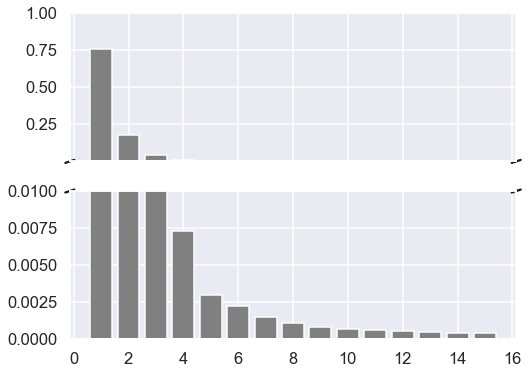

In [156]:
# 30 points between [0, 0.2) originally made using np.random.rand(30)*.2
plt.figure(figsize = (12,8))
# If we were to simply plot pts, we'd lose most of the interesting
# details due to the outliers. So let's 'break' or 'cut-out' the y-axis
# into two portions - use the top (ax) for the outliers, and the bottom
# (ax2) for the details of the majority of our data
f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize = (8,6))

# plot the same data on both axes
ax.bar(df1['PC'][0:15], df1['Explained'][0:15],color = 'grey' )
ax2.bar(df1['PC'][0:15], df1['Explained'][0:15], color = 'grey')

# zoom-in / limit the view to different portions of the data
ax.set_ylim(.00001, 1)  # outliers only
ax2.set_ylim(0, 0.01)  # most of the data

# hide the spines between ax and ax2
# ax.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax.xaxis.tick_top()
# ax.tick_params(labeltop=False)  # don't put tick labels at the top
# ax2.xaxis.tick_bottom()
#ax2.set_xlabel("Principal Components")
#ax2.set_ylabel("Explained Variance")

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# rects = ax.patches

# # Make some labels.
# labels = [round(i,3) for i in list(df1.Explained)]

# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
#             ha='center', va='bottom')

# plt.xlabel("Principal Components")
# plt.ylabel("Explained Variance")

In [157]:
sub_df.shape, df[indices].shape, df.shape, sub.shape

((831, 15), (831, 5), (831, 2175), (831, 2151))

In [158]:
#Add treatment and target variable on the PCs
#sub_df = pd.concat([sub_df, df[indices]], axis = 1, ignore_index= False)
for i in indices:
    sub_df[i] = list(df[i])
sub_df['DaysToBloom'] = list(df['DaysToBloom'])
sub_df['treatment'] = list(df.Treatment)
sub_df.head(3)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,EVI,RNDVI,ARVI,VRI,NDVI,DaysToBloom,treatment
0,-0.199795,0.475168,-0.180586,0.039666,-0.048019,0.119211,-0.037106,-0.014908,0.020054,0.029521,-0.031861,-0.018250,-0.010368,0.017520,0.028504,0.066424,0.496185,0.660642,1.620184,0.784569,76.0,HN
1,0.090690,-0.413289,-0.094177,0.047305,-0.016289,0.017910,0.047469,-0.022164,0.026508,0.024055,0.004648,-0.002279,-0.017012,0.035588,0.027102,0.070298,0.501770,0.666989,1.633299,0.789024,53.0,HN
2,0.857476,-0.055503,-0.292810,0.167199,-0.104094,0.032286,-0.018998,0.010292,0.011132,-0.059544,0.025399,0.025521,0.009700,0.012001,-0.003276,0.067754,0.566552,0.685932,1.789818,0.807314,55.0,HN


### Train Test Split

In [159]:
## Data Split
X = sub_df[sub_df.columns[:-2]]
y = sub_df[['treatment','DaysToBloom']]
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30)

train_data = pd.concat([X_train, y_train], axis = 1)
print(f"Train Dataset: {train_data.shape[0]} row/records. F: {train_data[train_data.treatment=='HN'].shape[0]} and N: {train_data[train_data.treatment =='LN'].shape[0]}\n")

test_data = pd.concat([X_test,y_test], axis = 1)
print(f"Train Dataset: {test_data.shape[0]} row/records. F: {test_data[test_data.treatment=='HN'].shape[0]} and N: {test_data[test_data.treatment =='LN'].shape[0]}")



Train Dataset: 581 row/records. F: 221 and N: 360

Train Dataset: 250 row/records. F: 77 and N: 173


## Important Functions

In [160]:
sub_df.shape, df.shape

((831, 22), (831, 2175))

In [161]:
len(df.PI.unique())

341

In [162]:
df.head()

PlotID Treatment         PI       CHL       EWT       LWC        SLA  \
1    5002        HN  PI 656011  512.3625  0.043236  0.768144  76.626487   
2    5003        HN  PI 576347  606.6625  0.033848  0.751805  89.492182   
3    5014        HN  PI 534117       NaN       NaN       NaN        NaN   
4    5015        HN     BTx623       NaN       NaN       NaN        NaN   
5    5016        HN     BTx623       NaN       NaN       NaN        NaN   

       N      P     K     Mg     Ca      S     Fe    Mn    B    Cu    Zn  \
1  2.916  0.387  2.24  0.143  0.447  0.196  134.0  34.0  4.6  12.5  27.0   
2  3.749  0.492  1.54  0.260  0.583  0.196  159.0  36.0  5.1  15.4  32.0   
3    NaN    NaN   NaN    NaN    NaN    NaN    NaN   NaN  NaN   NaN   NaN   
4    NaN    NaN   NaN    NaN    NaN    NaN    NaN   NaN  NaN   NaN   NaN   
5    NaN    NaN   NaN    NaN    NaN    NaN    NaN   NaN  NaN   NaN   NaN   

       X350      X351      X352      X353      X354      X355      X356  \
1  0.053529  0.087761  0.089831  0.066536  0.070464  0.065440  0.057905   
2  0.133649  0.113164  0.095398  0.095292  0.097985  0.089531  0.085457   
3  0.119853  0.089598  0.093482  0.111414  0.079122  0.059123  0.080614   
4  0.087480  0.102200  0.112072  0.109021  0.096971  0.088650  0.079650   
5  0.120226  0.070748  0.053416  0.070563  0.062600  0.046475  0.061267   

       X357      X358      X359      X360      X361      X362      X363  \
1  0.061879  0.087529  0.083688  0.066741  0.054267  0.042131  0.050978   
2  0.086694  0.082119  0.090674  0.082183  0.057630  0.074017  0.063699   
3  0.111972  0.087410  0.104930  0.096836  0.053224  0.080590  0.084966   
4  0.069502  0.061583  0.063581  0.063916  0.057499  0.052230  0.050146   
5  0.086586  0.061980  0.078884  0.087223  0.066724  0.066786  0.068153   

       X364      X365      X366      X367      X368      X369      X370  \
1  0.056994  0.045107  0.046368  0.043490  0.042569  0.050927  0.046258   
2  0.056483  0.072555  0.051468  0.052361  0.063759  0.055830  0.039474   
3  0.075567  0.074128  0.078823  0.067031  0.053021  0.057072  0.060873   
4  0.051929  0.057628  0.068537  0.071899  0.064342  0.049210  0.040311   
5  0.064134  0.055916  0.059502  0.050772  0.042891  0.052731  0.048797   

       X371      X372      X373      X374      X375      X376      X377  \
1  0.041853  0.043365  0.048262  0.047062  0.048264  0.051650  0.044692   
2  0.044329  0.059886  0.055076  0.055611  0.054215  0.045810  0.032091   
3  0.065333  0.067081  0.061981  0.071762  0.075621  0.067405  0.063775   
4  0.043344  0.052114  0.055250  0.051213  0.045734  0.043992  0.048554   
5  0.049588  0.052458  0.043302  0.051977  0.055814  0.048201  0.048429   

       X378      X379      X380      X381      X382      X383      X384  \
1  0.043194  0.040966  0.035022  0.041995  0.044352  0.042166  0.041462   
2  0.028689  0.033169  0.038722  0.042077  0.040161  0.037917  0.041208   
3  0.060381  0.061531  0.067389  0.065502  0.061511  0.059425  0.060912   
4  0.051052  0.050399  0.048936  0.053607  0.054198  0.049047  0.042811   
5  0.049429  0.050073  0.049999  0.047943  0.045547  0.044132  0.044034   

       X385      X386      X387      X388      X389      X390      X391  \
1  0.043841  0.043980  0.042063  0.041588  0.038251  0.035009  0.034469   
2  0.046213  0.048145  0.046461  0.043884  0.043052  0.039607  0.035373   
3  0.060602  0.060764  0.061790  0.062637  0.064547  0.063739  0.060583   
4  0.053208  0.055781  0.048785  0.046415  0.043908  0.047679  0.054650   
5  0.042231  0.042918  0.044714  0.043390  0.050289  0.052161  0.045801   

       X392      X393      X394      X395      X396      X397      X398  \
1  0.037531  0.040736  0.042420  0.042195  0.041240  0.040235  0.039823   
2  0.041091  0.045182  0.045669  0.043754  0.042794  0.041254  0.040067   
3  0.061476  0.058410  0.057525  0.062045  0.058640  0.057564  0.058823   
4  0.048783  0.052314  0.054007  0.045919  0.048827  0.052774  0.054797   
5  0.044632  0

In [163]:
def evaluate_model(y_true,preds):
    r2 = r2_score(y_true,preds)
    rmse = np.sqrt(mean_squared_error(y_true,preds))
    return (r2,rmse)
    

## RF  - Both Treatment

In [164]:
## Initialize Models with default parameters
xb = train_data[list(train_data.columns)[:-2]]
yb = train_data['DaysToBloom']
xb_test = test_data[list(test_data.columns)[:-2]]
yb_test =  test_data[['treatment', 'DaysToBloom']]


In [165]:
xb_test.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,EVI,RNDVI,ARVI,VRI,NDVI
671,1.056742,0.132256,-0.104480,0.045822,-0.026504,-0.018502,-0.038014,-0.017704,-0.050703,0.001874,0.042832,-0.000966,0.012281,-0.014082,0.005675,0.067295,0.551966,0.699838,1.684296,0.816564
320,1.246194,0.267904,-0.116114,-0.046986,-0.026460,0.107518,0.013646,0.059241,-0.024453,-0.030289,-0.003819,0.031766,0.041975,-0.018532,-0.004908,0.065410,0.549558,0.714791,1.645657,0.826957
535,0.166520,-0.148830,-0.058289,0.006400,-0.025061,0.054241,0.062915,-0.026771,-0.056083,-0.008927,-0.008458,-0.015003,0.015748,0.000957,-0.021972,0.068909,0.492905,0.675529,1.609095,0.794607
553,0.029877,-0.468830,0.064814,0.140164,-0.072183,0.020947,-0.012386,0.008334,0.034522,0.005089,0.000190,0.052428,-0.000464,0.011424,-0.004025,0.068797,0.476045,0.627734,1.582145,0.758802
720,-1.712080,0.253524,-0.157943,0.094146,0.089524,-0.049413,0.039488,-0.000550,-0.024221,0.044264,-0.000319,0.024224,0.010631,-0.035902,-0.017802,0.070771,0.458191,0.639797,1.528221,0.764749


### Train Base Model 

In [166]:
#initialize the ExtraTrees with 100 trees
#bencmark (150, 15, 45)	(0.29433576187237, 5.399180284621151)
model_b = ExtraTreesRegressor(
criterion = 'squared_error',
 max_depth =  45,
 max_features =  'auto',
 min_samples_split = 15,
 n_estimators =  150)
 
model_b.fit(xb,yb)


ExtraTreesRegressor(max_depth=45, min_samples_split=15, n_estimators=150)

In [167]:

#evaluate the base model
# >Base Model on Both Treatment Evaluation> Train R2: 0.7895357690411551, Train RMSE:2.9153089443231726 
# >Base Model on Both Treatment Evaluation> Test R2: 0.2796245239024938, Test RMSE:5.455169317417621 
preds_b = model_b.predict(xb_test)
score = evaluate_model(yb_test['DaysToBloom'],preds_b)
pred_t = model_b.predict(xb)
train_score = evaluate_model(yb, pred_t)

print(f">Base Model on Both Treatment Evaluation> Train R2: {train_score[0]}, Train RMSE:{train_score[1]} ")
print(f">Base Model on Both Treatment Evaluation> Test R2: {score[0]}, Test RMSE:{score[1]} ")


>Base Model on Both Treatment Evaluation> Train R2: 0.7878267864215119, Train RMSE:2.8616190606591876 
>Base Model on Both Treatment Evaluation> Test R2: 0.2764759124165732, Test RMSE:5.734866707026299 


In [168]:
r, p = sp.stats.pearsonr(yb_test['DaysToBloom'],preds_b)
print(r,p)

0.5523258097453723 2.2876064811729434e-21


In [169]:
yb_test['true_bd'] = preds_b 
temp_df = yb_test.copy()

C:\Users\ANISHI~1\AppData\Local\Temp/ipykernel_10976/495352928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yb_test['true_bd'] = preds_b


In [170]:
temp_df.head()

,treatment,DaysToBloom,true_bd
671,LN,69.0,67.501296
320,LN,60.0,67.340252
535,LN,58.0,64.094578
553,LN,65.0,65.156964
720,LN,60.0,61.208370


Overall:  0.5523258097453723 2.2876064811729434e-21
HN:  0.5671321481518791 0.5671321481518791
LN:  0.5020966316345987 1.9517986637770124e-12


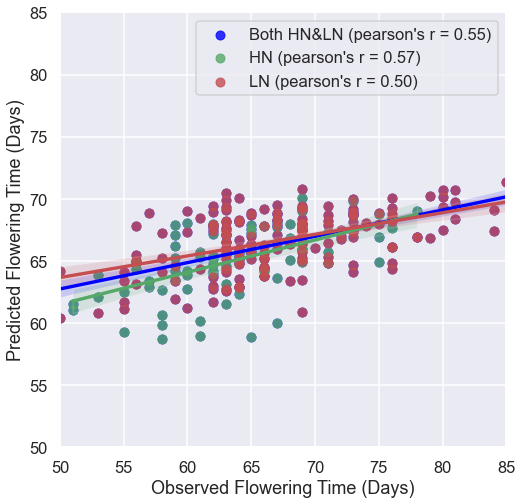

In [208]:
plt.figure(figsize = (8,8))
temp_df['treatment'] = pd.Categorical(temp_df['treatment'])
colors = temp_df['treatment'].cat.codes
sns.regplot(x ='DaysToBloom',y='true_bd',data =temp_df, color = 'blue', label = "Both HN&LN (pearson's r = 0.55)")
ro, po = sp.stats.pearsonr(temp_df['DaysToBloom'],temp_df['true_bd'])
# overall['model'],overall['level'] = [model],['Overall']
# overall['pearson-r'], overall['p-value'] = [ro], [po]
print("Overall: ",ro,po)
#standard nitrogen
sn = temp_df[temp_df.treatment =="HN"]
sns.regplot(x='DaysToBloom',y='true_bd', data = sn, color='g', label = "HN (pearson's r = 0.57)")
rsn, psn = sp.stats.pearsonr(sn['DaysToBloom'],sn['true_bd'])
# df_sn['model'],df_sn['level'] = [model],['Standard Nitrogen']
# df_sn['pearson-r'], df_sn['p-value'] = [rsn], [psn]
print("HN: ",rsn,rsn)

#limited nitrogen
ln = temp_df[temp_df.treatment =="LN"]
sns.regplot(x='DaysToBloom',y='true_bd', data = ln, color='r', label = "LN (pearson's r = 0.50)")
rln, pln = sp.stats.pearsonr(ln['DaysToBloom'],ln['true_bd'])
# df_ln['model'],df_ln['level'] = [model],['Limited Nitrogen']
# df_ln['pearson-r'], df_ln['p-value'] = [rln], [pln]
print("LN: ",rln,pln)
#plt.title("Observed vs. Predicted Flowering Days by Nitrogen Conditions")
plt.ylabel('Predicted Flowering Time (Days)')
plt.xlabel('Observed Flowering Time (Days)')
plt.ylim((50,85))
plt.xlim((50,85))
plt.legend()

